# Bayesian calibration

In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
from scipy import stats
import time
import arviz as az
import theano
import theano.tensor as tt
import GPy
from pyDOE import *
import pickle
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
import pymc3 as pm
from pymc3 import Model, Normal, Slice, sample, traceplot
from pymc3.distributions import Interpolated
import warnings
warnings.filterwarnings("ignore")


## Ground-truth data
strain_fe_adventitia = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35] 
strain_fe_adventitia = np.array(strain_fe_adventitia)[list(np.arange(0, len(strain_fe_adventitia), 2))]

stress_fe_adventitia = [0, 0.000967127, 0.00192, 0.00286563, 0.00381458, 0.00478288, 0.00579386, 0.00688035, 0.00808715, 0.00947402, 0.0111194, 0.013125, 0.0156211, 0.0187736, 0.0227912, 0.0279346, 0.0345266, 0.0429626, 0.053722, 0.0673801, 0.0846188, 0.106237, 0.133158, 0.166435, 0.207249, 0.256905, 0.316817, 0.388482, 0.473446, 0.573248, 0.689352, 0.823053, 0.975359, 1.14685, 1.33748, 1.54637] #, 1.77155, 2.00962, 2.25541, 2.50152, 2.73783]
stress_fe_adventitia = np.array(stress_fe_adventitia)[list(np.arange(0, len(stress_fe_adventitia), 2))]


## Initial set of coefficients 
initial_coeffs = [0.014,0,0,0,40,175]

def max_coeff(order):  
    
    ''' Approximation of coefficients of polynomial function based on the order of the polynomial '''
    
    return (initial_coeffs[-1]*strain_fe_adventitia[-1]**6)/(strain_fe_adventitia[-1]**order)

c1_max = initial_coeffs[0]*1.5
c2_max = max_coeff(1)
c3_max = max_coeff(2)
c4_max = max_coeff(3)
c5_max = initial_coeffs[4]*1.5
c6_max = initial_coeffs[5]*1.5

## Loading pre-trained Gaussian process model

with open('GPy_model.pkl', 'rb') as file:
    GP_model = pickle.load(file)
    

Running on PyMC3 v3.11.2


In [2]:
def create_parameters_set(strain_fe_adventitia, coefficient_sets):
    
    ''' Creation of parameters set: [strain value, c1, ...c6] '''
    
    parameter_space = []
    for i in range(len(strain_fe_adventitia)):
        parameter_space.append(np.insert(coefficient_sets, 0, strain_fe_adventitia[i])) 
    return np.array(parameter_space)

def model_prediction(theta1, theta2, theta3, theta4 , theta5, theta6):
    
    ''' GP model prediction for the specific set of parameters  '''
    
    coefficient_set = np.array([theta1, theta2, theta3, theta4, theta5, theta6])    
    test_par_set = create_parameters_set(strain_fe_adventitia, coefficient_set)  
    simY, simMse = GP_model.predict(test_par_set)
    
    return simY.squeeze()

def sample_from_posterior(param_name, theta):
    '''
    Estimation of the PDF of a random variable by Gaussian Kernel density estimation method;
    
    A linear interpolation of pdf is evaluated on evenly distributed points from interval 
    between 0 and maximum value of posterior theta +- considerable margins.
    
    '''
    
    margin = np.max(theta) - np.min(theta)
    x = np.linspace(np.min(theta), np.max(theta), 200)
    y = stats.gaussian_kde(theta)(x)
    
    # Extend the domain and use linear approximation of density on it
    
    x = np.concatenate([[max(x[0] - 3 * margin,0)], x, [x[-1] + 3 * margin]])
    y = np.concatenate([[0], y, [0]])
    
    return Interpolated(param_name, x, y)

In [4]:
## Ground-truth data used for calibration
calibration_data = stress_fe_adventitia


## LogLikelihood and gradient of the LogLikelihood functions

def log_likelihood(theta, data, t):
    
    ''' 
    Likelihood defined as a joint Gaussian distribution, whose mean is calibration data 
    given GP model response for the prior uncertain parameters and the variance is sigma, 
    where sigma is modelling error variance.

    '''
    
    if type(theta) == list:
        theta = theta[0]
    (theta1, theta2, theta3, theta4, theta5, theta6, sigma) = theta
    
    y_pred = my_model_prediction(theta1, theta2, theta3, theta4 , theta5, theta6)
    
    logp = -len(data) * np.log(np.sqrt(2.0 * np.pi) * sigma) -
           np.sum((data - y_pred) ** 2.0) / (2.0 * sigma ** 2.0)
        
    return logp


def der_log_likelihood(theta, data, t):
    '''
    Finite-difference approximation of the gradient of a likelihood function.
    '''
    def lnlike(values):
        return log_likelihood(values, data, t)

    eps = np.sqrt(np.finfo(float).eps)
    grads = scipy.optimize.approx_fprime(theta[0], lnlike, eps * np.ones(len(theta)))
    
    return grads

## Wrapper classes to theano-ize LogLikelihood and gradient

class Loglikelihood(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dscalar]

    def __init__(self, data, t):
        self.data = data
        self.t = t
        self.loglike_grad = LoglikeGrad(self.data, self.t)

    def perform(self, node, inputs, outputs):
        logp = log_likelihood(inputs, self.data, self.t)
        outputs[0][0] = np.array(logp)

    def grad(self, inputs, grad_outputs):
        (theta,) = inputs
        grads = self.loglike_grad(theta)
        return [grad_outputs[0] * grads]

class LoglikeGrad(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, data, t):
        self.der_likelihood = der_log_likelihood
        self.data = data
        self.t = t

    def perform(self, node, inputs, outputs):
        (theta,) = inputs
        grads = self.der_likelihood(inputs, self.data, self.t)
        outputs[0][0] = grads

## Define Likelihood
Loglikelihood = Loglikelihood(calibration_data, strain_fe_adventitia)

In [5]:
'''
First itertaion of Bayesian calibration, where posterior is obtained from original prior information
'''
tick = time.time() 
traces = []
with pm.Model() as model:
    # Sample from prior distributions of IUQ parameters
    theta1 = pm.Uniform("theta_1", lower=0, upper=0.021)
    theta2 = pm.Uniform("theta_2", lower=0, upper=0.7951)
    theta3 = pm.Uniform("theta_3", lower=0, upper=2.3385)
    theta4 = pm.Uniform("theta_4", lower=0, upper=7)
    theta5 = pm.Uniform("theta_5", lower=0, upper=60)
    theta6 = pm.Uniform("theta_6", lower=0, upper=270)
    sigma  = pm.HalfNormal("sigma", sigma=0.6, testval=0.01)
    
    # Convert parameters to a tensor vector
    theta = tt.as_tensor_variable([theta1, theta2, theta3, theta4, theta5, theta6, sigma])
    
    # Create model likelihood with corresponding name
    pm.Potential("Likelihood", Loglikelihood(theta))
    
    # Sample posterior information
    trace = pm.sample_smc(500, parallel=True) 
    
    print(pm.summary(trace).to_string())
    
traces.append(trace)   

tock = time.time()
print("Execution time:", tock - tick)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs
Stage:   0 Beta: 0.091
Stage:   1 Beta: 0.213
Stage:   2 Beta: 0.383
Stage:   3 Beta: 0.600
Stage:   4 Beta: 0.895
Stage:   5 Beta: 1.000


            mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
theta_1    0.010   0.006    0.000    0.019      0.000    0.000    2054.0    1922.0    1.0
theta_2    0.169   0.148    0.001    0.456      0.003    0.002    1891.0    2012.0    1.0
theta_3    0.206   0.253    0.002    0.626      0.006    0.004    2123.0    1686.0    1.0
theta_4    2.482   1.963    0.016    6.084      0.044    0.032    2010.0    1946.0    1.0
theta_5   10.959   9.076    0.194   26.016      0.208    0.147    1933.0    1907.0    1.0
theta_6  224.376  28.027  175.872  267.323      0.637    0.450    1959.0    1999.0    1.0
sigma      0.064   0.015    0.039    0.091      0.000    0.000    2063.0    1928.0    1.0
Execution time: 556.3868162631989


In [6]:
pm.save_trace(trace, 'trace_smc_3_0.trace')   

'trace_smc_3_0.trace'

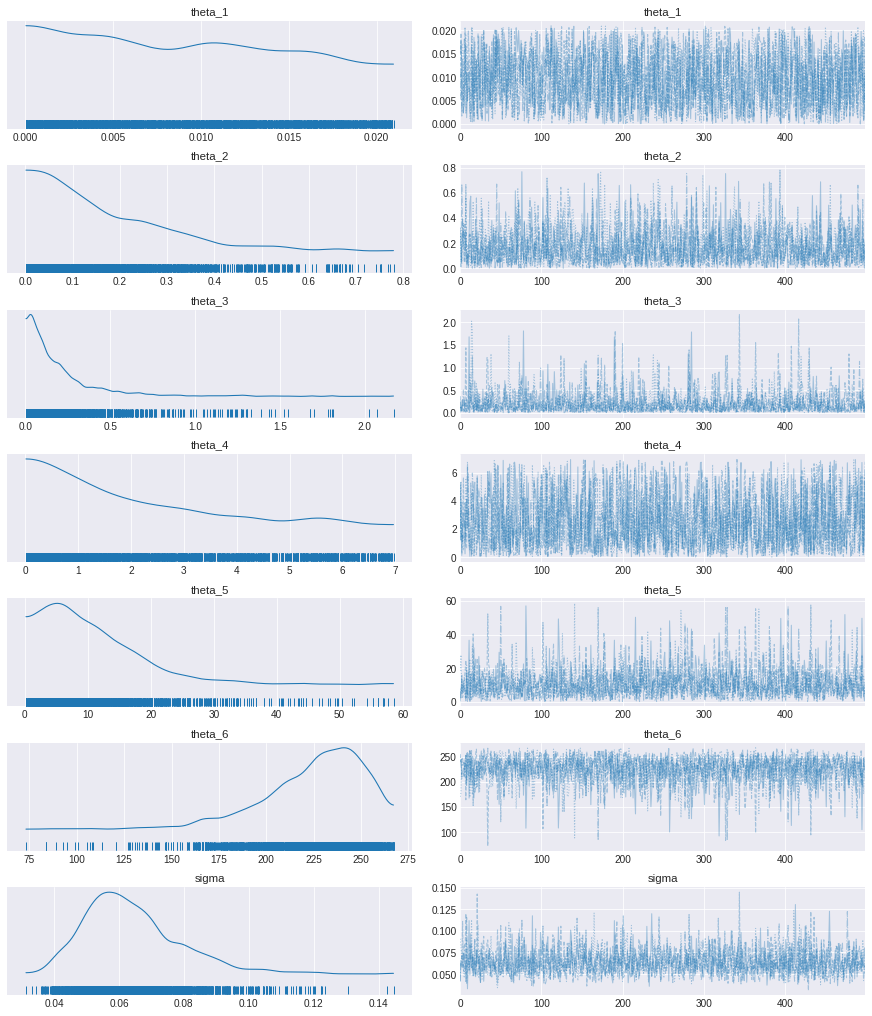

In [7]:
pm.traceplot(trace, 
    var_names=["theta_1", "theta_2",   "theta_3", "theta_4", "theta_5",  "theta_6",   "sigma"], 
             divergences=None, combined=True, rug = True);


# Calibration 

In [1]:
'''
Iteratively performing the calibration process, where obtained posterior distributions
are used as the prior distributions for the next iteration of Bayesian inference
'''

model = pm.Model()
with model:
    for i in np.arange(27,30,1):
        print(i)
        tick = time.time()
        # New priors are posteriors from the previous iteration
        theta1 = sample_from_posterior("theta_1", traces[-1]["theta_1"])
        theta2 = sample_from_posterior("theta_2", traces[-1]["theta_2"])
        theta3 = sample_from_posterior("theta_3", traces[-1]["theta_3"])
        theta4 = sample_from_posterior("theta_4", traces[-1]["theta_4"])
        theta5 = sample_from_posterior("theta_5", traces[-1]["theta_5"])
        theta6 = sample_from_posterior("theta_6", traces[-1]["theta_6"]) 
        sigma  = pm.Normal("sigma",  mu = np.mean(traces[-1]["sigma"]  ), sigma = np.std(traces[-1]["sigma"]))

        # Convert parameters to a tensor vector
        theta = tt.as_tensor_variable([theta1, theta2, theta3, theta4, theta5, theta6, sigma])
        pm.Potential("like", loglike(theta))
        trace = pm.sample_smc(500, parallel=True)
        pm.summary(trace)
        
        traces.append(trace) 
        pm.save_trace(trace, 'trace_smc_New_%s.trace'%(i+1))   
        
        tock = time.time()
        print("Execution time:", tock - tick)



In [32]:
pm.summary(traces[-1])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,0.046,0.002,0.042,0.050,0.000,0.000,1911.0,1893.0,1.0
theta_1,0.023,0.016,0.001,0.047,0.000,0.000,1969.0,1972.0,1.0
theta_2,0.042,0.027,0.001,0.085,0.001,0.000,1928.0,1895.0,1.0
theta_3,0.023,0.015,0.000,0.047,0.000,0.000,1883.0,1835.0,1.0
theta_4,15.403,0.609,14.279,16.512,0.014,0.010,1920.0,2036.0,1.0
theta_5,13.148,2.129,9.286,17.067,0.047,0.033,2074.0,1968.0,1.0
theta_6,218.844,3.205,213.044,224.646,0.069,0.049,2180.0,1836.0,1.0


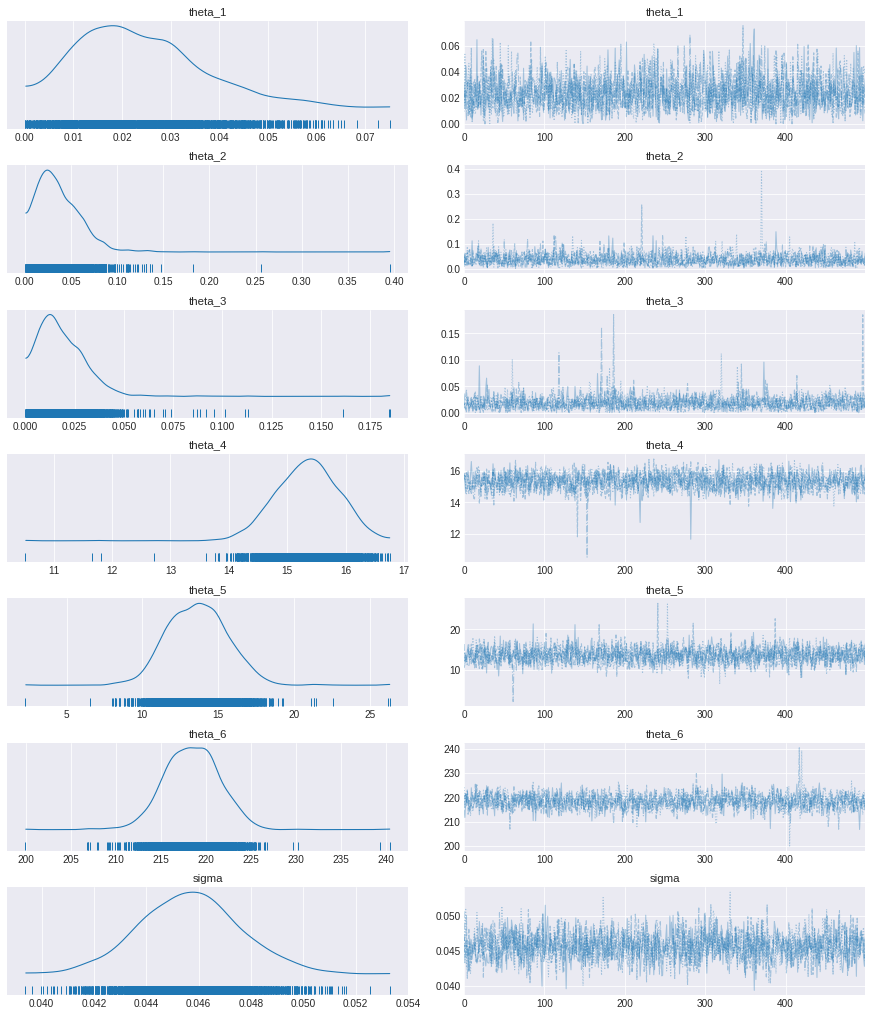

In [48]:
pm.traceplot(traces[-1], 
    var_names=["theta_1", "theta_2",   "theta_3", "theta_4", "theta_5",  "theta_6",   "sigma"], 
             divergences=None, combined=True, rug = True);


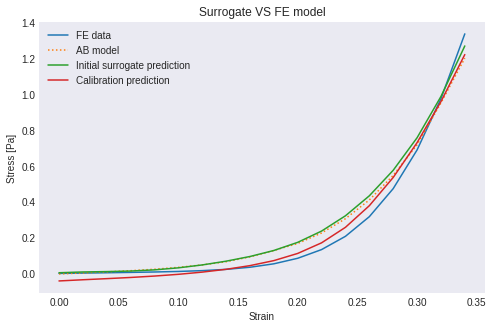

In [78]:
'''
Test in experimental data 
'''

initial_coeffs = np.array([0.014,0,0,0,40,175])

## Obtain mean values of the posterior distributions for each parameter from the last iteration 
N = -1
calibrated_coeffs = np.array([np.mean(trace[N]["theta_1"]),
                              np.mean(trace[N]["theta_2"]),
                              np.mean(trace[N]["theta_3"]),
                              np.mean(trace[N]["theta_4"]),
                              np.mean(trace[N]["theta_5"]),
                              np.mean(trace[N]["theta_6"])])


## GP model prediction for initial coefficients
FE_set = create_parameters_set(strain_fe_adventitia, initial_coeffs )
calibrated_set = create_parameter_set(strain_fe_adventitia, calibrated_coeffs)

## GP model prediction for calibrated coefficients 
simY_FE, simMse_FE = GP_model.predict(FE_set)
simY_calibrated, simMse_calibrated = GP_model.predict(calibrated_set)

## AB model response for calibrated coefficients 
AB = [-0.00283393,0.00263095,0.00860905,0.0152457,0.0234279,0.0339502,0.0476025,0.0653891,0.0925499,0.128252,0.16718,0.225922,0.305606,0.410193,0.547404,0.718079,0.951887,1.2017]


plt.figure(figsize=(8,5))
plt.plot(strain_fe_adventitia, stress_fe_adventitia, label ="FE data" )
plt.plot(strain_fe_adventitia, AB, ":", label ="AB model" )
plt.plot(strain_fe_adventitia, simY_FE,label = "Initial surrogate prediction")
plt.plot(strain_fe_adventitia,  simY_calibrated,label = "Calibration prediction")
plt.xlabel("Strain")
plt.ylabel("Stress [MPa]")
plt.title("Surrogate VS FE model")
plt.legend()
plt.show()